In [3]:
# import all library required
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl

# style your matplotlib
mpl.style.use("seaborn-darkgrid")
# run this block


C:\Users\Asus\AppData\Local\Temp\ipykernel_17224\3665540914.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use("seaborn-darkgrid")


In [4]:
from tqdm import tqdm # show progress bar of for loop

In [5]:
# list of files in train folder
files=os.listdir("C:/Users/Asus/Desktop/project_app_mobile/input/mma-facial-expression/MMAFEDB/train/")
files

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [6]:
# now create image and label array
image_array=[]  # it's a list later i will convert it to array
label_array=[]
path="C:/Users/Asus/Desktop/project_app_mobile/input/mma-facial-expression/MMAFEDB/train/"
# loop through each sub-folder in train
for i in range(len(files)):
    # files in sub-folder
    file_sub=os.listdir(path+files[i])

   # print(len(file_sub))
    # loop through each files
    
    # for neutral and happy dataset we will use only 18000 image
    if(files[i]=="neutral" or files[i]=="happy"):
        for k in tqdm(range(18000)):
            # read image
            img=cv2.imread(path+files[i]+"/"+file_sub[k])
            # convert image from BGR to RGB
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            # append image_array with img
            image_array.append(img)
            label_array.append(i)
            # i is interger from 0-6
            # run this block
    else:
        # for other all 
        for k in tqdm(range(len(file_sub))):
            # read image
            img=cv2.imread(path+files[i]+"/"+file_sub[k])
            # convert image from BGR to RGB
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            # append image_array with img
            image_array.append(img)
            label_array.append(i)
            # i is interger from 0-6
            # run this block

100%|█████████████████████████████████████████████████████████████████████████████| 8113/8113 [00:49<00:00, 164.11it/s]


In [7]:
a,b=np.unique(label_array,return_counts="True")
a

array([0, 1, 2, 3, 4, 5, 6])

In [8]:
b
# due to low ram memory we have to reduce our training dataset
# we will reduce 29384,28592 to 18000
# this will solve low memory issue

array([ 6566,  3231,  4859, 18000, 18000, 12223,  8113], dtype=int64)

In [9]:
# now use this to free some ram memory
import gc
gc.collect()

8

In [10]:
# now divide image_array by 255.0
# this wil scale image pixel from 0-255 to 0-1
image_array=np.array(image_array)/255.0
# convert label list to array
label_array=np.array(label_array)
# run this block

In [11]:
# now define label_to_text 
#['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
label_to_text={0:"surprise",1:"fear",2:"angry",3:"neutral",4:"sad",5:"disgust",6:"happy"}

In [12]:
# this dic can convert label to text_label
# example
label_to_text[1]

'fear'

In [13]:
from sklearn.model_selection import train_test_split
image_array,X_test,Y_train,Y_test=train_test_split(image_array,label_array,test_size=0.1)
# you can change test size 
# we are using 10% for validation

#now before running this block change X_train to image_array to save ram memory
gc.collect()

0

In [14]:
# if you want to see image and label
# define dic for converting label to test_label
#['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
label_to_text={0:"surprise",1:"fear",2:"angry",3:"neutral",4:"sad",5:"disgust",6:"happy"}

In [15]:
label_to_text[2]

'angry'

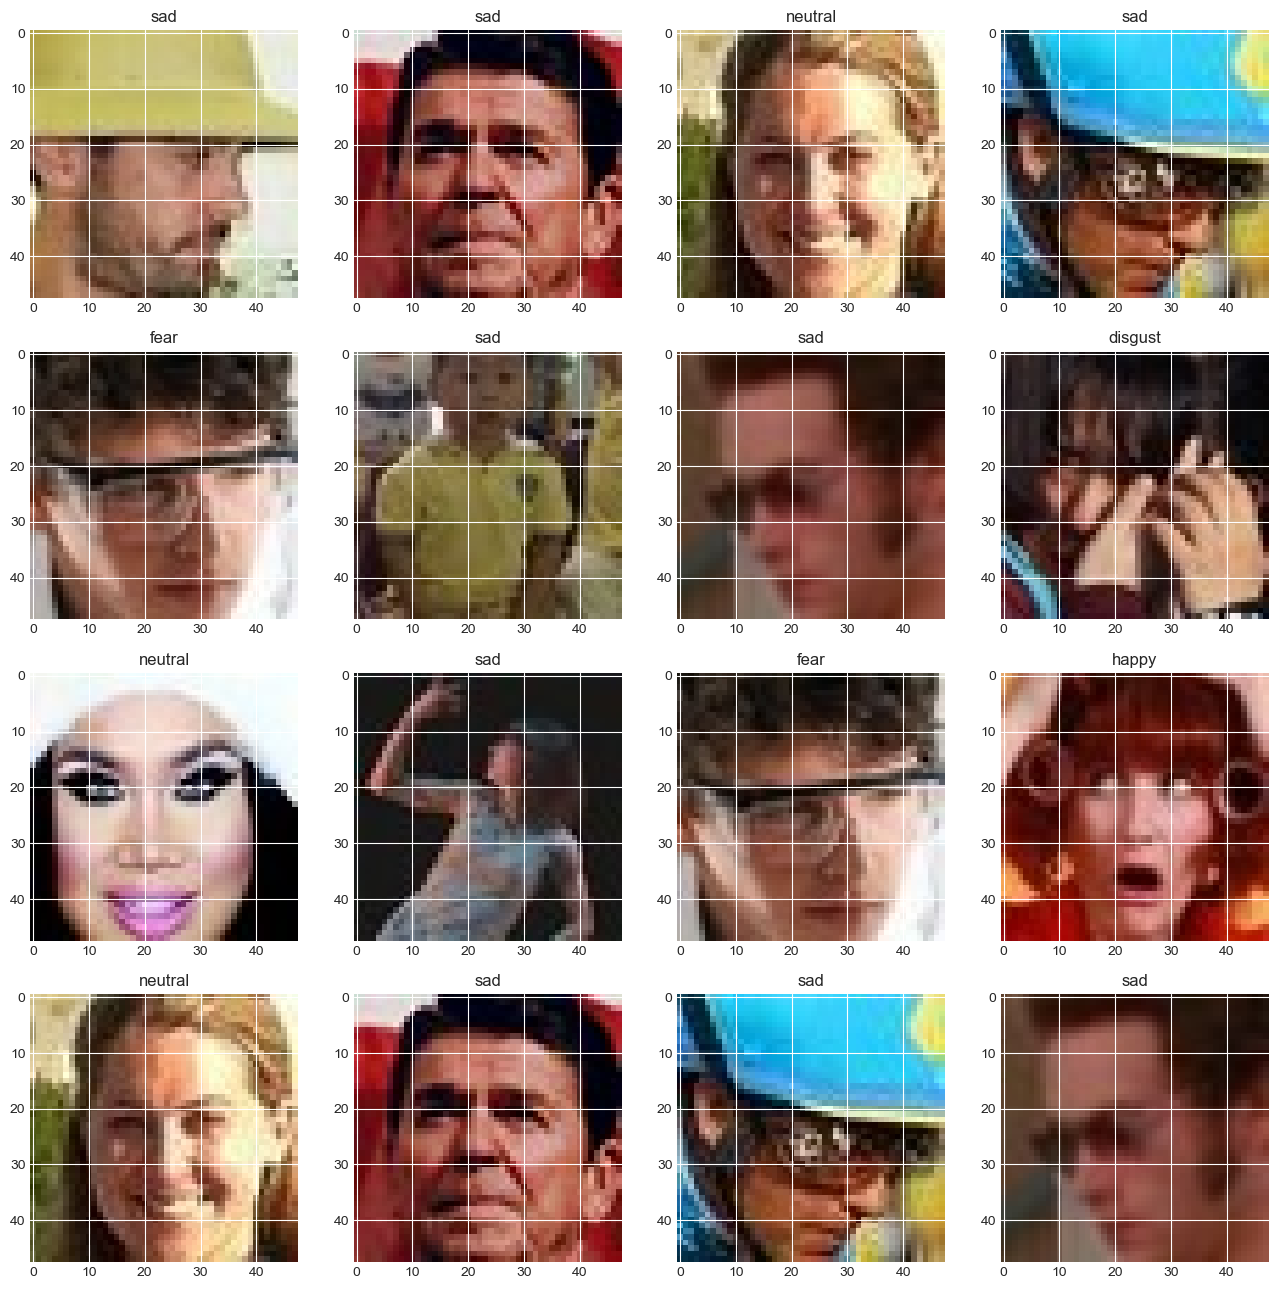

In [16]:
# define a function 
def show_examples(image,label,idx):
    # create 4x4 figure
    fig,axes=plt.subplots(nrows=4,ncols=4,figsize=(16,16))
    # loop through each figure
    for idx_f,ax in zip(idx,axes.ravel()):
        # add image to figure
        ax.imshow(image[idx_f].squeeze(),cmap="gray")
        # add title to each figure
        ax.set_title(label_to_text[label[idx_f]])
    plt.show()
idx=np.random.choice(16,16)
show_examples(image_array,Y_train,idx)


In [17]:
# now we will start with our model
# import all library required for model
from keras import layers,callbacks,utils,applications,optimizers
from keras.models import Sequential,Model,load_model
# run this block

In [18]:
model=Sequential()
# I will use MobileNetV2 as an pretrained model 
pretrained_model=applications.MobileNetV2(input_shape=(48,48,3),include_top=False,
                                         weights="imagenet")
# you can use other pretrained model to increase accuracy or increase frame rate
# change all non-trainable layer to trainable
pretrained_model.trainable=True
# add pretrained_model to model
model.add(pretrained_model)
model.add(layers.GlobalAveragePooling2D())
# add dropout to increase accuracy by not overfitting
model.add(layers.Dropout(0.3))
# add dense layer as final output
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 2225153 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [19]:
from tensorflow.keras.optimizers import Adam

In [20]:
#compile model

model.compile(optimizer=Adam(0.0001),loss="mean_squared_error",metrics=["mae"])
# run
# starting learning rate is 1e-3
# you can change optimizer, loss function, metrics for better result

In [21]:
# create a model checkpoint to save model
ckp_path="trained_model/model"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=ckp_path,
                                                   monitor="val_mae",
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   mode="auto")
# this checkpoint save model when val_mae is lower then best val_mae
#run

In [22]:
# now we will define learning rate reducer 
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(factor=0.9,
                                              monitor="val_mae",
                                              mode="auto",
                                              cooldown=0,
                                              patience=5,
                                              verbose=1,
                                              min_lr=1e-6)
# this will decrease learning rate when val_mae does't decrease durning last 5 epoch
# verbose is use to show val_mae every epoch


In [23]:
EPOCHS=300
BATCH_SIZE=64
# start training
history=model.fit(image_array,Y_train,
                 validation_data=(X_test,Y_test),
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 callbacks=[model_checkpoint,reduce_lr])
#run

Epoch 1/5


KeyboardInterrupt: 

In [24]:
# after training is finished 
# load best model
model.load_weights(ckp_path)

In [25]:
# if you want to see result
prediction_val=model.predict(X_test,batch_size=BATCH_SIZE)


111/111 [==============================] - 6s 50ms/step


In [26]:
# prediction value 
prediction_val[:10]

array([[7.0475626],
       [6.991361 ],
       [7.371288 ],
       [9.112267 ],
       [8.948012 ],
       [7.2937284],
       [9.191192 ],
       [9.190836 ],
       [8.211494 ],
       [8.191133 ]], dtype=float32)

In [27]:
# original value
Y_test[:10]

array([1, 5, 6, 5, 3, 4, 1, 4, 4, 5])

In [28]:
# now convert model to tensorflow lite model 
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

#save model 
with open("model.tflite","wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Asus\AppData\Local\Temp\tmp428293ks\assets


INFO:tensorflow:Assets written to: C:\Users\Asus\AppData\Local\Temp\tmp428293ks\assets


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# โหลดโมเดล
model = tf.keras.models.load_model('your_model.h5')

# ทำการพยากรณ์ด้วยข้อมูล
predictions = model.predict(x_test)  # x_test เป็นข้อมูลทดสอบของคุณ

# พล็อตกราฟ
plt.figure(figsize=(10, 5))
plt.plot(predictions, label='Predictions')
plt.plot(y_test, label='Actual Values')  # y_test เป็นค่าที่ต้องการทำนาย
plt.legend()
plt.show()
